In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy

from statsmodels.sandbox.regression.gmm import GMM
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

 **Note**: In the final section, there is a table with all the coefficients together for comparison. However, first we complete each estimation procedure one by one. The individual tables for each estimation procedure contain standard errors as well as the estimated coefficients. The overall tables in the final section do not have parameters for inference


# Part A: Ordinary Least Squares

For this assignment we are interested in estimating

$$y_{it} = \beta^k k_{it} + \beta^l l_{it} + \omega_{it} + \epsilon_{it}$$

First we estimate OLS as a baseline model. As usual, we underestimate the coefficient on capital because capital investment is correlated with the trend $\omega_{it}$. This is the motivation behind the various control function approaches which have become standard in the literature.

In [2]:
#load data into memory
data = pd.read_stata('chile.dta')
data = data.set_index(['id','year'], drop=False)

In [3]:
ldata = data.copy()

ldata[['routput', 'totlab', 'renerg','realmats',
       'rcapstock']] = np.log(ldata.copy()[['routput','totlab', 'renerg','realmats','rcapstock']])

ldata = ldata.dropna()

## OLS: Estimated parameters

In [4]:
olsmodel = smf.ols('routput ~ totlab + renerg + realmats + rcapstock',ldata)
olsresult = olsmodel.fit()
olsresult.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                routput   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                 1.359e+05
Date:                Wed, 15 May 2019   Prob (F-statistic):               0.00
Time:                        16:48:32   Log-Likelihood:                -4619.4
No. Observations:               20717   AIC:                             9249.
Df Residuals:                   20712   BIC:                             9289.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3535      0.015     89.079      0.000       1.324       1.383
totlab         0.1643      0.004     42.376      0.000       0.157       0.172
renerg         0.1025      0.002     45.094      0.000       0.098       0.107
realmats       0.7352      0.003    290.483      0.000       0.730       0.740
rcapstock      0.0644      0.002     38.010      0.000       0.061       0.068
==============================================================================
Omnibus:                    10161.910   Durbin-Watson:                   1.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           136680.009
Skew:                           2.025   Prob(JB):                         0.00
Kurtosis:                      14.914   Cond. No.                         124.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## OLS: Hicks neutral shocks

In this case the 'Hicks neutral' productivity shock is just the error term from the regression. We show a histogram and plot it over time.

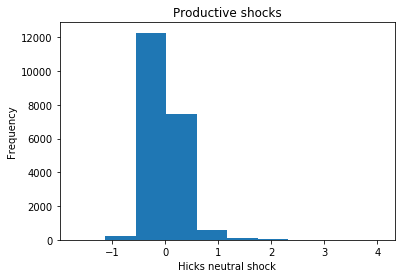

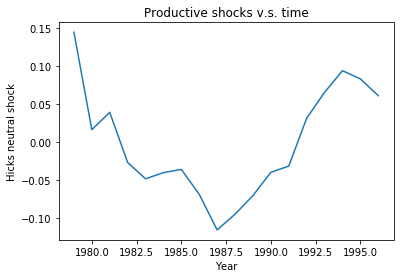

In [5]:
shockols = olsresult.resid
plt.hist(shockols)
plt.xlabel('Hicks neutral shock')
plt.ylabel('Frequency')
plt.title('Productive shocks')
plt.show()

mean_shockols = shockols.groupby('year').mean()
plt.plot(mean_shockols)
plt.title('Productive shocks v.s. time')
plt.ylabel('Hicks neutral shock')
plt.xlabel('Year')
plt.show()

# Part B: Fixed effects

Next we perform the wthin transformation on the data i.e. 

$$\ddot{y}_{it} = y_{it} - \bar{y}_i$$ and $$\ddot{x}_{it} =  x_{it} - \bar{x}_i$$

This differences out any 'firm-specific' characteristics. If $\omega_{it}$ were constant within a firm, then this approach would consistently estimate the parameters. We see that the capital coefficient does increase when we use the fixed effects approach indicating that we have reduced the bias.

In [6]:
def add_fe(df, dfvars,groups):
    """apply the within transformation"""
    for var in dfvars: #,
        df[var+'fe'] = df[var]
        for fe in groups:
            dum = pd.get_dummies(fedata[fe])
            means = np.tile(fedata[var],len(dum.columns)).reshape(len(dum.columns),fedata.shape[0])
            means = np.array(means.transpose()*dum)
            means = means.sum(axis=0)/dum.sum(axis=0)
            means = np.tile(means,fedata.shape[0]).reshape(fedata.shape[0],len(dum.columns))
            means = (means*dum).sum(axis=1)
            df[var+'fe'] = df[var+'fe'] - means
    return df


fedata = ldata.copy()
fedata = add_fe(fedata, ['routput','totlab', 'renerg','realmats','rcapstock'], ['id'])

## FE: Estimated parameters

In [7]:
femodel = smf.ols('routputfe ~ totlabfe + renergfe + realmatsfe + rcapstockfe -1',fedata)
feresult = femodel.fit()
feresult.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              routputfe   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                 1.511e+04
Date:                Wed, 15 May 2019   Prob (F-statistic):               0.00
Time:                        16:48:45   Log-Likelihood:                 3385.1
No. Observations:               20717   AIC:                            -6762.
Df Residuals:                   20713   BIC:                            -6731.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
totlabfe        0.1904      0.005     40.301      0.000       0.181       0.200
renergfe        0.0626      0.002     27.477      0.000       0.058       0.067
realmatsfe      0.6073      0.003    179.527      0.000       0.601       0.614
rcapstockfe     0.0508      0.003     18.381      0.000       0.045       0.056
==============================================================================
Omnibus:                     4681.848   Durbin-Watson:                   1.560
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            49300.045
Skew:                           0.785   Prob(JB):                         0.00
Kurtosis:                      10.392   Cond. No.                         2.58
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## FE: Hicks neutral shocks

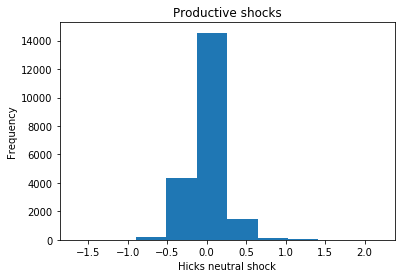

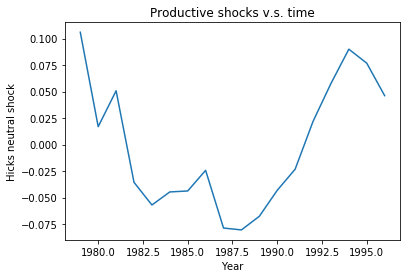

In [8]:
shockfe = feresult.resid
plt.hist(shockfe)
plt.xlabel('Hicks neutral shock')
plt.ylabel('Frequency')
plt.title('Productive shocks')
plt.show()

mean_shockfe = shockfe.groupby('year').mean()
plt.plot(mean_shockfe)
plt.title('Productive shocks v.s. time')
plt.ylabel('Hicks neutral shock')
plt.xlabel('Year')
plt.show()

# Part C: Levinsohn Petrin

Following the literature we will use a control function approach for $\omega_{it}$ in our estimation procedure. The idea behind Levinsohn and Petrin's control function involves using intermediate inputs $m_{it}$ as a proxy variable

## LP: Stage 1

The first stage of Levinsohn and Petrin involves non-parametrically estimating the relationship between $y_{it}$ and $m_{it}$, $k_{it}$  with an index coefficient on $l_{it}$
$$y_{it} = \beta^l l_{it} + f(k_{it},m_{it}) + \epsilon_{it}$$ 

This model was first estimated by Robinson (1988).  In order to do this, we just use a third order polynomial to represent our estimated versions of $E(l_{it}|k_{it},m_{it})$ and  $E(y_{it}|k_{it},m_{it})$. Using $E(l_{it}|k_{it},m_{it})$ and  $E(y_{it}|k_{it},m_{it})$ we can regress each of these quantities on eachother to consistently estimate $\beta^l$.

In [9]:
d1 = ldata['routput'],ldata[['renerg','totlab']],ldata[['rcapstock','realmats']]

def np_resids(y,x):
    """residuals from a 3 order polynomial"""
    y,x = y.dropna(),x.dropna()
    
    poly = PolynomialFeatures(degree=3)
    x_poly = poly.fit_transform(x)
    clf = Ridge(alpha=0.0)
    clf.fit(x_poly, y) 
    resid = y-clf.predict(x_poly)
    return resid

In [10]:
def robinson(dta):
    """y is dependent variable
    x has parametric coefficients
    z is nonparameteric variables"""
    
    y,x,z = dta
    
    y_resid = np_resids(y,z)
    x_resid = []
    for col in x.columns:
        resid = np_resids(x[col],z)
        x_resid.append(resid)
    x_resid = np.array(x_resid).transpose()
    x_resid = pd.DataFrame(data=x_resid,columns=x.columns)
    return sm.OLS(np.array(y_resid),x_resid)


d = ldata['routput'],ldata[['renerg','totlab']],ldata[['rcapstock','realmats']]
stage1 = robinson(d)
stage1_res = stage1.fit()
stage1_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     2512.
Date:                Wed, 15 May 2019   Prob (F-statistic):               0.00
Time:                        16:48:46   Log-Likelihood:                -3246.9
No. Observations:               20717   AIC:                             6498.
Df Residuals:                   20715   BIC:                             6514.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
renerg         0.0858      0.002     39.327      0.000       0.082       0.090
totlab         0.1688      0.004     45.672      0.000       0.162       0.176
==============================================================================
Omnibus:                     6304.969   Durbin-Watson:                   1.064
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            60355.585
Skew:                           1.186   Prob(JB):                         0.00
Kurtosis:                      11.018   Cond. No.                         1.83
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## LP: Stage 2

Now we estimate the parameters on $m_{it}$ and $k_{it}$ following appendix C in the paper. To do this we  'predict' $E(\omega_{it}|\omega_{it-1})$ to construct valid moments that can estimate the system. As we can see the coefficient on capital is almost double that estimated by OLS.

In [11]:
def lpobj(zparams, xparams, dta):
    """Note: z are the instruments in the stage 1 control function
    i.e. materials and capital
    
    x are the productive inputs who's effect was
    estimated in the first stage"""
    
    y,x,z = dta
    #########compute production trend and shock ##############
    shock1 = y - x.mul(xparams,axis=1).sum(axis=1) - z.mul(zparams,axis=1).sum(axis=1)

    ######  compute trend and shock ############
    #compute the value added by z + shock
    zvalue = y - x.mul(xparams,axis=1).sum(axis=1)
    
    ##### predict the value added by z############3
    zvalue_predict = zvalue - np_resids(zvalue, z)
    
    ######### predict the difference#########
    shock2 = zvalue_predict - z.mul(zparams,axis=1).sum(axis=1)

    #####compute expected production trend############
    shock2lag = shock2.groupby('id').shift(1)
    both_shocks = pd.concat((shock1,shock2lag),axis=1).dropna()
    trend = shock1 - np_resids(both_shocks[[0]],both_shocks[[1]])[0]
    
    ####subtract this trend from the shock ###########
    shock3 = shock1 - trend
    
    #####multiply by lags to get moment condition #########
    moments  = pd.concat((x,z),axis=1).groupby('id').shift(1)
    moments = moments.mul(shock3,axis=0) 
    return moments.dropna()

In [12]:
class LP(GMM):
    
    def __init__(self, dta, stage1_params, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        y,x,z = dta
        super(LP, self).__init__(y,x,z, x.shape[1] +z.shape[1],*args, **kwds)
        self.endog = y
        self.exog = x
        self.instr = z
        self.stage1_params = stage1_params
        
        self.data.xnames = [col for col in z.columns]
        
    def momcond(self, params):
        d = self.endog, self.exog, self.instr
        return np.array(lpobj(params, self.stage1_params , d))
        
        
d = ldata['routput'],ldata[['renerg','totlab']],ldata[['rcapstock','realmats']]
lpmodel = LP(d,stage1_res.params)
lpresult = lpmodel.fit(np.array([.1,.5]),optim_method='nm')
lpresult.summary()

Optimization terminated successfully.
         Current function value: 0.000147
         Iterations: 27
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.000842
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.000842
         Iterations: 18
         Function evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000842
         Iterations: 19
         Function evaluations: 36


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  LP Results                                  
==============================================================================
Dep. Variable:                routput   Hansen J:                        15.20
Model:                             LP   Prob (Hansen J):              0.000501
Method:                           GMM                                         
Date:                Wed, 15 May 2019                                         
Time:                        16:49:03                                         
No. Observations:               20717                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
rcapstock      0.1346      0.060      2.262      0.024       0.018       0.251
realmats       0.6137      0.091      6.770      0.000       0.436       0.791
==============================================================================
"""

## LP: Hicks neutral shocks

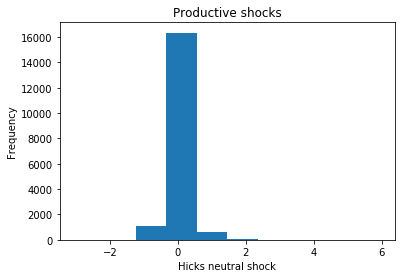

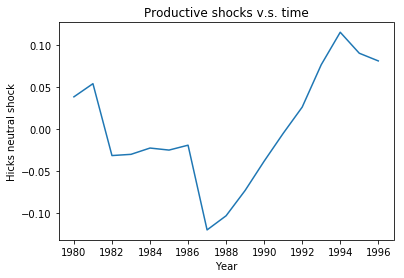

In [13]:
shocklp =  (lpobj(lpresult.params,stage1_res.params, d)['renerg']).div(ldata['renerg'])
shocklp = shocklp.dropna()

plt.hist(shocklp)
plt.xlabel('Hicks neutral shock')
plt.ylabel('Frequency')
plt.title('Productive shocks')
plt.show()


mean_shocklp = shocklp.groupby('year').mean()
plt.plot(mean_shocklp)
plt.title('Productive shocks v.s. time')
plt.ylabel('Hicks neutral shock')
plt.xlabel('Year')
plt.show()

# Part D: Ackerberg Caves Frazer

Now we use Ackerberg Caves and Frazer's approach to estimating production functions. This approach does not involve estimating any parameters as part of the control function. Instead it estimates all the parameters in the second stage of the estimation procedure. In particular it uses the fact that

$$E\left[y_{it} - \beta_0 - \beta^k k_{it} - \beta^l l_{it} - \rho( \tilde{\Phi}(k_{it-1},l_{it-1},m_{it-1}) - \beta_0 - \beta^k k_{it-1} - \beta^l l_{it-1}) \right] = 0$$ 


Here $\tilde{\Phi}$ is estimated in the first stage (again using a third order polynomial). We have also assumed that $\omega_{it}$ is an AR(1) process with parameter $\rho$. Our estimates using the procedure seem high. This might be related to the fact that we are looking at gross $y_{it}$ for the sake of comparability with the other sections instead of a value added production function.

In [14]:
def acfobj(params, stage1_resids, dta):
    y,x = dta
    
    rho = params[-1]
    theta = params[:-1]
    
    xlag= x.groupby('id').shift(1)
    
    ####### compute the value of the control function from stage 1
    control = y - stage1_resids
    controllag = control.groupby('id').shift(1)
    
    ####### compute the value of the shock #########
    #this is just the moment condition computed above
    shock = (y - x.mul(theta,axis=1).sum(axis=1) 
             - rho*(controllag- xlag.mul(theta,axis=1).sum(axis=1) ) )    

    #####multiply to get moment condition #########
    moments = pd.concat((x, controllag),axis=1)
    moments = moments.mul(shock,axis=0)
    return moments.dropna()

In [15]:
class ACF(GMM):
    
    def __init__(self, dta, stage1_resid, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        y,x = dta
        super(ACF, self).__init__(y,x,stage1_resid, x.shape[1] + 1 ,*args, **kwds)
        self.endog = y
        self.exog = x
        self.instr = stage1_resid
        self.data.xnames = list(x.columns) + ['rho']
        
    def momcond(self, params):
        d = self.endog, self.exog
        return np.array( acfobj(params, self.instr , d) )

    
#in the first stage get the fitted residuals
acf_resids = np_resids(ldata['routput'],ldata[['totlab','rcapstock','renerg','realmats']])    
d = ldata['routput'],sm.add_constant( ldata[['rcapstock','totlab']])
 
# in the second stage do the actual estimation
d = ldata['routput'],sm.add_constant( ldata[['rcapstock','totlab']])
acfmodel = ACF(d, acf_resids)
acfresult = acfmodel.fit(np.array([2]+2*[.5]+[1]),optim_method='nm')
acfresult.summary()

Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 229
         Function evaluations: 404
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 142
         Function evaluations: 240
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 80
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 80
         Function evaluations: 132


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ACF Results                                  
==============================================================================
Dep. Variable:                routput   Hansen J:                    2.094e-07
Model:                            ACF   Prob (Hansen J):                   nan
Method:                           GMM                                         
Date:                Wed, 15 May 2019                                         
Time:                        16:49:21                                         
No. Observations:               20717                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9447      0.187     26.485      0.000       4.579       5.311
rcapstock      0.4232      0.022     19.429      0.000       0.380       0.466
totlab         0.6008      0.025     24.425      0.000       0.553       0.649
rho            0.9356      0.006    154.331      0.000       0.924       0.947
==============================================================================
"""

# ACF: Hicks neutral shocks

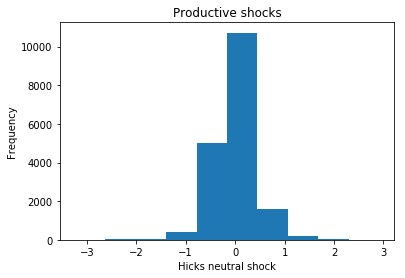

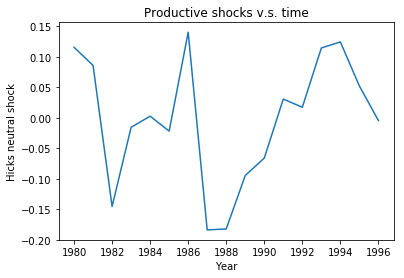

In [16]:
shockacf =  acfobj(acfresult.params, acf_resids, d)['const']
plt.hist(shockacf)
plt.xlabel('Hicks neutral shock')
plt.ylabel('Frequency')
plt.title('Productive shocks')
plt.show()

mean_shockacf = shockacf.groupby('year').mean()
plt.plot(mean_shockacf)
plt.title('Productive shocks v.s. time')
plt.ylabel('Hicks neutral shock')
plt.xlabel('Year')
plt.show()

# Summary 

Below we summarize the results from the various estimation routines (without standard errors). The standard errors are in the tables in the individual sections that describe the procedure.

In [17]:
print '######## OLS ########'
print olsresult.params
print '######## FE #########'
print feresult.params
print '######## LP #########'
print pd.DataFrame(np.concatenate((stage1_res.params,lpresult.params)),['renerg','totlab','rcapstock','realmats'])
print '######## ACF ########'
print pd.DataFrame(acfresult.params,['Intercept','rcapstock','totlab','rho'])

######## OLS ########
Intercept    1.353477
totlab       0.164328
renerg       0.102450
realmats     0.735187
rcapstock    0.064443
dtype: float64
######## FE #########
totlabfe       0.190441
renergfe       0.062644
realmatsfe     0.607337
rcapstockfe    0.050753
dtype: float64
######## LP #########
                  0
renerg     0.085776
totlab     0.168798
rcapstock  0.134580
realmats   0.613693
######## ACF ########
                  0
Intercept  4.944699
rcapstock  0.423175
totlab     0.600755
rho        0.935611


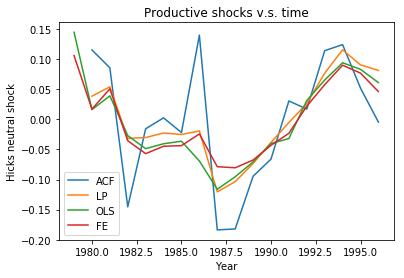

In [18]:
mean_shockacf = shockacf.groupby('year').mean()
plt.plot(mean_shockacf,label='ACF')
plt.plot(mean_shocklp,label='LP')
plt.plot(mean_shockols,label='OLS')
plt.plot(mean_shockfe,label='FE')
plt.title('Productive shocks v.s. time')
plt.ylabel('Hicks neutral shock')
plt.xlabel('Year')
plt.legend()
plt.show()